In [1]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, StratifiedShuffleSplit, train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import log_loss, matthews_corrcoef, roc_auc_score
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, RocCurveDisplay,auc
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

In [2]:
import requests
import numpy as np
import pandas as pd
import time
import os
from pyspark.sql.window import Window
from math import ceil
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from datetime import timedelta, datetime
from sqlalchemy import create_engine
from urllib import parse
from pyspark.sql.functions import regexp_replace, regexp_extract
from pyspark.sql.functions import *

In [3]:
import sys
sys.path.append('/data/gtair/tools/DWH')
from GlodonSparkSession3 import GlodonSparkSession
import os
from pyspark.sql import functions as F

In [4]:
spark = GlodonSparkSession().getSparkSession()

===============>app_name: gaokx_low_114076101
=====================>resource_lev: low


23/08/04 01:10:09 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/04 01:10:10 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/08/04 01:10:10 WARN util.Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/08/04 01:10:10 WARN util.Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
23/08/04 01:10:11 WARN shortcircuit.DomainSocketFactory: The short-circuit local reads feature cannot be used because libhadoop cannot be loaded.
23/08/04 01:10:12 WARN yarn.Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.
23/08/04 01:10:20 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental

In [7]:
base_data=spark.read.option("header","true").csv("/tmp/lig-u/ods_jst_success_bid_company.csv")

23/07/31 01:08:46 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 3 were expected.


In [8]:
base_data = base_data.dropDuplicates(subset=[c for c in base_data.columns if c in ["company_name"]])

In [9]:
base_data=base_data.select('company_name','province')

In [10]:
base_data = base_data.withColumn('province', regexp_replace('province',
                                                             '省|市|自治区', ''))
base_data.groupBy('province').count().orderBy(desc('count')).show(40)

23/07/31 01:08:48 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 18 were expected.


+-------------------+-----+
|           province|count|
+-------------------+-----+
|               江苏|48451|
|               山东|45045|
|               广东|37439|
|               浙江|31084|
|               河南|30437|
|               四川|30003|
|               安徽|27138|
|               陕西|25441|
|               湖北|24409|
|               河北|23235|
|               山西|18770|
|               甘肃|15921|
|             内蒙古|15920|
|               福建|15702|
|             黑龙江|14487|
|               江西|13414|
|               辽宁|13140|
|               北京|12730|
|               湖南|12469|
|                 无|11956|
|               云南|11428|
|               上海|10248|
|               新疆| 9814|
|               贵州| 9584|
|               广西| 9114|
|               吉林| 8829|
|               null| 8768|
|               天津| 7932|
|               重庆| 7641|
|               青海| 4825|
|               宁夏| 4076|
|               海南| 3009|
|               西藏| 2839|
|               全国|   48|
|               null|    5|
|  

In [11]:
base_data.createOrReplaceTempView("base_data")

In [50]:
base_customer=spark.read.option("header","true").csv("/tmp/lig-u/st02_data/customer_dim.csv/")

In [51]:
base_customer = base_customer.dropDuplicates(subset=[c for c in base_customer.columns if c in ["accnt_name"]])

In [52]:
base_customer.show()

23/08/02 02:58:22 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 7 were expected.


+------------+------------+----------+--------------------------------------+--------------+------------------+--------------+------------+------------+---------+------------+--------------+--------+---------------------+----------------+------+------------+--------------------+
|customer_wid|account_code|  accnt_id|                            accnt_name|      province| social_credit_num|regist_capital|  unit_level|act_category|act_alias|ent_category|     ent_level|industry|           accnt_type|            kq1j|branch|  management|             created|
+------------+------------+----------+--------------------------------------+--------------+------------------+--------------+------------+------------+---------+------------+--------------+--------+---------------------+----------------+------+------------+--------------------+
|    23285582|      638390| 1-5CS-539|            &nbsp;辽宁林业职业技术学院|        辽宁省|              null|          null|      公司级|        null|     null|  中小型用户|      

In [14]:
base_customer = base_customer.select('customer_wid','accnt_name','province')

In [15]:
base_customer = base_customer.withColumn('province', regexp_replace('province',
                                                             '省|市|自治区|壮族|回族', ''))
#base_customer.groupBy('province').count().orderBy(desc('count')).show(40)

In [16]:
base_customer.createOrReplaceTempView("base_customer")

In [17]:
#base_data.filter(F.length(base_data.company_name)<7).count() ###去掉6个

In [18]:
base_customer2 = base_customer.filter(F.length(base_customer['accnt_name']) >= 7)

In [19]:
base_customer2.count()

23/07/31 01:09:56 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 14 were expected.


790816

In [20]:
df1 = base_data.join(base_customer2,base_data.company_name==base_customer2.accnt_name,'inner') ## 2817543/3580515=0.7869099836196748

In [21]:
df1.count()

23/07/31 01:10:40 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 18 were expected.
23/07/31 01:10:40 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 14 were expected.


64146

In [22]:
customer_list = [row['accnt_name'] for row in df1.select('accnt_name').collect()]

23/07/31 01:11:18 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 18 were expected.
23/07/31 01:11:18 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 14 were expected.


In [23]:
base_customer_rest = base_customer2.filter(base_customer2['accnt_name'].isin(customer_list)==False)

In [24]:
base_data_rest = base_data.filter(base_data['company_name'].isin(customer_list)==False)

In [25]:
#base_data_rest[base_data_rest['company_name'].like('%)%')].show(5)

In [26]:
base_data_rest = base_data_rest.withColumn('company_name_new', regexp_replace('company_name',
                                                             '[`~!@#$%^&*()_\-+=<>?:"{}|,.\/;\'\[\]]', ''))
base_customer_rest = base_customer_rest.withColumn('accnt_name_new', regexp_replace('accnt_name',
                                                             '[`~!@#$%^&*()_\-+=<>?:"{}|,.\/;\'\[\]]', ''))

In [27]:
pandas_base = base_data_rest.toPandas()

23/07/31 01:16:15 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 18 were expected.
23/07/31 01:16:32 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB


In [28]:
pandas_customer = base_customer_rest.toPandas()

23/07/31 01:16:47 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 12 were expected.
23/07/31 01:16:53 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB


In [22]:
# -*- coding: utf-8 -*-
import jieba
s=pandas_base['company_name_new'].to_list()+pandas_customer['accnt_name_new'].to_list()
counts = {}
for i in s:
    token = jieba.lcut(i)
    for word in token:
        if len(word)==1:
            continue
        else:
            counts[word] = counts.get(word, 0) + 1
items = list(counts.items())
items.sort(key=lambda x: x[1], reverse=True) 

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.747 seconds.
Prefix dict has been built successfully.


In [23]:
df_word = pd.DataFrame(index=list(range(0,len(items))),columns=['word','num'])
for i in range(len(items)):
    df_word.iloc[i]=[items[i][0],items[i][1]]
df_word.head()

,word,num
0,有限公司,963650
1,隐藏,266753
2,工程,171125
3,2021922,147846
4,公司,117446


In [24]:
df_word.to_csv('word.csv')

In [29]:
delete = ['有限公司','隐藏','工程','2021922','公司','预算','建筑工程','分公司','集团','科技','建筑','有限责任','项目部','部已','开发',
         '设计','发展','置业','投资','项目','项目管理','建筑安装','20200619','20200316','安装','2020924','建工','工程部','造价','SG','实业','股份','技术',
          '中建','设备','工程造价', '农业','中铁','广告', '建设', '建设工程'
         '服务','经营部','环保','20200227','商贸','中心','研究院','智能','成本','技术部','20200228','国际','信息技术',
          '机电设备','工程建设','20200218',
         '建筑设计','环境','工程局','文化','广告','电子科技','电梯','集团股份','监理','事务所','路桥','工程技术','电气','勘察',
          '绿化','工程设计','交通',
         '电子','建材','20220822','20201022','丢失','2020928','2020930','科技股份','招标','建安','承建','工业','贸易','地产',
          '合作社','个人','世纪','工程项目',
         '专业','钢结构','办事处','规划','环境工程','旅游','规划设计','2020927','广场','经济','20201014','生态','检测','城建']
delete.sort(reverse=True)

In [30]:
delete_string = ''
for i in range(len(delete)):
    if i==len(delete)-1:
        delete_string = delete_string+delete[i]
    else:
        delete_string = delete_string+delete[i]+'|'
delete_string

'预算|项目部|项目管理|项目|集团股份|集团|隐藏|钢结构|部已|造价|路桥|贸易|设计|设备|规划设计|规划|股份|置业|绿化|经营部|经济|科技股份|科技|研究院|监理|电气|电梯|电子科技|电子|生态|环境工程|环境|环保|检测|机电设备|有限责任|有限公司|智能|旅游|文化|招标|投资|技术部|技术|承建|成本|开发|建设工程服务|建设|建筑设计|建筑工程|建筑安装|建筑|建材|建工|建安|广场|广告|广告|工程项目|工程部|工程造价|工程设计|工程技术|工程建设|工程局|工程|工业|实业|安装|城建|地产|国际|商贸|合作社|发展|勘察|办事处|分公司|农业|公司|信息技术|交通|事务所|中铁|中心|中建|个人|丢失|世纪|专业|SG|20220822|2021922|2020930|2020928|2020927|2020924|20201022|20201014|20200619|20200316|20200228|20200227|20200218'

In [31]:
base_data_rest = base_data_rest.withColumn('company_name_del', regexp_replace('company_name_new',
                                                             delete_string, ''))
base_customer_rest = base_customer_rest.withColumn('accnt_name_del', regexp_replace('accnt_name_new',
                                                             delete_string, ''))

In [65]:
base_data_rest = base_data_rest.withColumn('company_name_del', regexp_replace('company_name_del',
                                                             '[0-9]+', ''))
base_customer_rest = base_customer_rest.withColumn('accnt_name_del', regexp_replace('accnt_name_del',
                                                             '[0-9]+', ''))

In [4]:
from pyspark.sql.functions import desc

In [34]:
count = base_data_dropna.groupby('company_name_del').count().orderBy(desc("count"))
count = count.filter(count['count'] == 1).select('company_name_del')

In [5]:
from pyspark.sql.types import *
#schema = StructType([
#        StructField("accnt_name", StringType(), True),
#        StructField("accnt_name_del", StringType(), True),
#        StructField("company_name", StringType(), True)])
#df = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)

In [67]:
base = base_data_rest.filter(base_data_rest['company_name_del'] != '').withColumnRenamed('province','province_base')
customer = base_customer_rest.filter(base_customer_rest['accnt_name_del'] != '').withColumnRenamed('province','province_customer')
def func(base, customer, area, area_del):
    string_del = '('
    for j in range(len(area_del)):
        if j != len(area_del)-1:
            string_del = string_del+area_del[j]+'|'
        else:
            string_del = string_del+area_del[j]+')'
    if area_del != []:
        base = base.withColumn('class',regexp_extract(F.col("company_name"), string_del , 0))
        base = base.filter(F.col('class')=='')
        customer = customer.withColumn('class',regexp_extract(F.col("accnt_name"), string_del , 0))
        customer = customer.filter(F.col('class')=='')
        
    schema = StructType([
        StructField("accnt_name", StringType(), True),
        StructField("accnt_name_del", StringType(), True),
        StructField("company_name", StringType(), True),
        StructField("class", StringType(), True)])
    df = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)
    
    for i in range(len(area)):
        string = '%'+area[i]+'%'
        base_data_build = base.filter(base['company_name'].like(string))
        base_customer_build = customer.filter(customer['accnt_name'].like(string))
        df_del_build = base_data_build.join(base_customer_build,(base_data_build.company_name_del==base_customer_build.accnt_name_del)
                               &(base_data_build.province_base==base_customer_build.province_customer),'inner').select('accnt_name','accnt_name_del','company_name',
                                                                                                                       'province_base','province_customer')
        df_f_build = df_del_build.join(count,df_del_build.accnt_name_del==count.company_name_del,'inner').dropDuplicates(subset=['accnt_name_del'])\
                        .withColumn('class',F.lit(area[i])).select('accnt_name','accnt_name_del','company_name','class')
        df = df.union(df_f_build)
        base = base.filter(~F.col('company_name').like(string))
        customer = customer.filter(~F.col('accnt_name').like(string))
    return df

In [79]:
area = ['建筑工程','建设工程','科技','装饰','房地产','咨询','设计',
        '投资','劳务','项目管理','安装','造价','环保','电力','园林绿化','市政工程','商贸','智能','信息','电力工程','机电设备','工程建设','建筑设计','园林','环境']

In [77]:
area = ['机电设备','工程建设','建筑设计','园林','环境']
area_del = ['建筑工程','建设工程','科技','装饰','房地产','咨询','设计',
        '投资','劳务','项目管理','安装','造价','环保','电力','园林绿化','市政工程','商贸','智能','信息','电力工程']

In [70]:
dfa = func(base,customer,area,area_del)
dfa.cache()
dfa.repartition(40).write.mode('overwrite').option("header","true").csv("/tmp/lig-u/gkx_fuzzy_match_a.csv")

23/07/31 02:17:27 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 12 were expected.
23/07/31 02:17:27 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 14 were expected.
23/07/31 02:17:27 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/07/31 02:17:27 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 14 were expected.
23/07/31 02:17:36 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:17:36 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:17:36 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:17:36 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:17:36 WARN scheduler.DAGScheduler: Broadcasting large task binar

In [72]:
dfb = func(base,customer,area,area_del)
dfb.cache()
dfb.repartition(40).write.mode('overwrite').option("header","true").csv("/tmp/lig-u/gkx_fuzzy_match_b.csv")

23/07/31 02:21:22 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 12 were expected.
23/07/31 02:21:22 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 14 were expected.
23/07/31 02:21:22 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/07/31 02:21:22 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 14 were expected.
23/07/31 02:21:30 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:21:30 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:21:30 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:21:30 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:21:30 WARN scheduler.DAGScheduler: Broadcasting large task binar

In [74]:
dfc = func(base,customer,area,area_del)
dfc.cache()
dfc.repartition(40).write.mode('overwrite').option("header","true").csv("/tmp/lig-u/gkx_fuzzy_match_c.csv")

23/07/31 02:25:27 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 12 were expected.
23/07/31 02:25:27 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 14 were expected.
23/07/31 02:25:27 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/07/31 02:25:27 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 14 were expected.
23/07/31 02:26:32 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:26:32 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:26:32 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:26:32 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:26:32 WARN scheduler.DAGScheduler: Broadcasting large task binar

In [76]:
dfd = func(base,customer,area,area_del)
dfd.cache()
dfd.repartition(40).write.mode('overwrite').option("header","true").csv("/tmp/lig-u/gkx_fuzzy_match_d.csv")

23/07/31 02:30:58 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 14 were expected.
23/07/31 02:30:59 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 12 were expected.
23/07/31 02:30:59 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/07/31 02:30:59 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 14 were expected.
23/07/31 02:31:05 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:31:05 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:31:05 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:31:05 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:31:05 WARN scheduler.DAGScheduler: Broadcasting large task binar

In [78]:
dfe = func(base,customer,area,area_del)
dfe.cache()
dfe.repartition(40).write.mode('overwrite').option("header","true").csv("/tmp/lig-u/gkx_fuzzy_match_e.csv")

23/07/31 02:35:18 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 12 were expected.
23/07/31 02:35:18 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 14 were expected.
23/07/31 02:35:18 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/07/31 02:35:18 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 14 were expected.
23/07/31 02:35:24 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:35:24 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:35:24 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:35:24 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/07/31 02:35:24 WARN scheduler.DAGScheduler: Broadcasting large task binar

In [83]:
dfa = spark.read.option("header","true").csv("/tmp/lig-u/gkx_fuzzy_match_a.csv")

In [84]:
dfb = spark.read.option("header","true").csv("/tmp/lig-u/gkx_fuzzy_match_b.csv")

In [85]:
dfc = spark.read.option("header","true").csv("/tmp/lig-u/gkx_fuzzy_match_c.csv")

In [86]:
dfd = spark.read.option("header","true").csv("/tmp/lig-u/gkx_fuzzy_match_d.csv")

In [87]:
dfe = spark.read.option("header","true").csv("/tmp/lig-u/gkx_fuzzy_match_e.csv")

In [88]:
df_last = spark.read.option("header","true").csv("/tmp/lig-u/gkx_fuzzy_match_last2.csv")

In [91]:
df_last.count()

23/07/31 02:40:07 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 4 were expected.


1794

In [89]:
dff = dfa.union(dfb).union(dfc).union(dfd).union(dfe).union(df_last)

In [94]:
df1=df1.select('company_name','accnt_name')
dff=dff.select('company_name','accnt_name')

In [95]:
df_match = df1.union(dff)

In [103]:
df_match.write.option("header","true").csv("/tmp/lig-u/gkx_fuzzy_match_all.csv")

23/07/31 02:49:53 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 12 were expected.
23/07/31 02:49:53 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 8 were expected.
23/07/31 02:50:59 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 12 were expected.


In [29]:
df_match=spark.read.option('header','true').csv('/tmp/lig-u/gkx_fuzzy_match_all.csv')

23/08/04 01:31:11 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 3 were expected.


In [53]:
df_match.printSchema()

root
 |-- company_name: string (nullable = true)
 |-- accnt_name: string (nullable = true)



22222222222222222222222222

In [27]:
base=spark.read.option("header","true").csv("/tmp/lig-u/ods_jst_success_bid_company.csv")\
            .select('company_name','bid_win_date','amount','project_name','project_type','province').withColumn('province', regexp_replace('province',
                                                             '省|市|自治区', ''))
customer=spark.read.option("header","true").csv("/tmp/lig-u/st02_data/customer_dim.csv/").select('customer_wid','accnt_name','province')\
                .withColumn('province', regexp_replace('province',
                            '省|市|自治区|壮族|回族', ''))

23/08/04 01:30:50 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 2 were expected.
23/08/04 01:30:54 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 2 were expected.


In [28]:
base=base.withColumn('amount',F.col('amount').cast('int')).withColumn('date',F.col('bid_win_date').cast(DateType())).drop('bid_win_date')

In [78]:
join = base.join(df_match,'company_name','inner')

In [79]:
join=join.withColumn('project_type', regexp_replace('project_type', 'null', '无'))
join=join.withColumn('project_type', regexp_replace('project_type', '"', '')).fillna({'project_type':'无'}).filter(F.col('amount')>=5000000)

In [80]:
join=join.join(customer,on=['accnt_name','province'],how='inner').drop('company_name','accnt_name','province')

In [ ]:
#pivotedDF = Exploded.groupBy("company_name").pivot("split_values").agg(count("split_values")).fillna(0)
#a = pivotedDF.summary('mean').toPandas()

#a = a.iloc[:,2:]

#a = a.astype('float')
#a['Row_sum'] = a.apply(lambda x: x.sum(), axis=1)

#a.loc['Col_sum'] = a.apply(lambda x: x.sum()/20.472514)

#a = a.transpose()
#b = a[a['Col_sum']>=0.005]

In [33]:
#keep = b.index.to_list()[:-1]
#keep
keep = ['公路',
 '勘察设计',
 '园林绿化',
 '市政',
 '弱电',
 '房建',
 '无',
 '机电',
 '水利',
 '水利水电',
 '消防',
 '环保',
 '电力',
 '装修装饰',
 '通信']

In [77]:
#Exploded = join.withColumn("split_values", split("project_type", ",")).withColumn("split_values", explode("split_values"))

In [78]:
#Exploded=Exploded.withColumn('split_values', when(Exploded.split_values.isin(keep), Exploded.split_values).otherwise('其他'))

In [80]:
#pivotedDF = Exploded.groupBy("customer_wid","date").pivot("split_values").agg(count("project_name")).fillna(0)
#pivotedDF.show()

23/08/02 07:00:32 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 5 were expected.
23/08/02 07:01:42 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 3 were expected.
23/08/02 07:01:48 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 5 were expected.


+------------+----------+----+----+--------+--------+----+----+----+---+----+----+--------+----+----+----+--------+----+
|customer_wid|      date|公路|其他|勘察设计|园林绿化|市政|弱电|房建| 无|机电|水利|水利水电|消防|环保|电力|装修装饰|通信|
+------------+----------+----+----+--------+--------+----+----+----+---+----+----+--------+----+----+----+--------+----+
|    23469173|2023-04-11|   0|   0|       0|       0|   0|   0|   1|  0|   0|   0|       0|   0|   0|   0|       0|   0|
|    48696313|2021-12-21|   0|   0|       0|       0|   0|   0|   0|  1|   0|   0|       0|   0|   0|   0|       0|   0|
|   649667999|2022-02-17|   0|   0|       0|       0|   0|   0|   0|  1|   0|   0|       0|   0|   0|   0|       0|   0|
|    45681464|2021-08-09|   0|   0|       0|       0|   0|   0|   0|  1|   0|   0|       0|   0|   0|   0|       0|   0|
|    23180057|2021-05-31|   0|   0|       0|       0|   0|   0|   0|  1|   0|   0|       0|   0|   0|   0|       0|   0|
|    23180057|2021-10-19|   0|   0|       0|       0|   0|   0|   0|  2

In [15]:
from datetime import *

In [35]:
def func2(df,df_date):
    df = df.join(df_date,'customer_wid','inner').withColumn('date_diff',F.datediff(F.col('date_end'),F.col('date')))
    ## Time intervals be setted
    time = [(0,15),(15,30),(30,60),(60,120)]
    for i in range(len(time)):
        ## time interval settings
        #end = date+timedelta(days=-time[i][0])
        #start = date+timedelta(days=-time[i][1])
    
        ## Split project type
        Exploded = df.withColumn("split_values", split("project_type", ",")).withColumn("split_values", explode("split_values"))\
                    .filter((F.col('date_diff')>=time[i][0])&(F.col('date_diff')<=time[i][1]))
        ## Keep the key values and mark the rest as 其他 (Keep在函数外)
        Exploded = Exploded.withColumn('split_values', when(Exploded.split_values.isin(keep), Exploded.split_values).otherwise('其他'))
        ## Get the pivot table of project type
        pivotedDF = Exploded.groupBy("customer_wid","date_end").pivot("split_values").agg(count("split_values")).fillna(0)
    
        ## Get aggregated values of col amount, project name and total project type in the time intervals
        tmp = df.filter((F.col('date_diff')>=time[i][0])&(F.col('date_diff')<=time[i][1]))
        tmp = tmp.groupBy('customer_wid',"date_end").agg(F.sum('amount').alias('sum_amont'),
                                F.count('project_name').alias('工程数'),
                                F.countDistinct('project_name').alias('去重工程数'),
                                F.countDistinct('project_type').alias('工程种类')).join(pivotedDF,on=['customer_wid','date_end'],how='inner') ## Join with pivot table
    
        ## Rename cols
        col = tmp.columns[2:]
        col_date = []
        for j in range(len(col)):
            a = [col[j]+'_'+str(time[i][1])]
            col_date = col_date+a
    
        mapping = dict(zip(col, col_date)) ## Mapping original col name with new name
        tmp = tmp.select([F.col(c).alias(mapping.get(c, c)) for c in tmp.columns])
             
        ## The pivot table of amount
        pivotedDF2 = Exploded.groupBy("customer_wid","date_end").pivot("split_values").agg(sum("amount")).fillna(0)
        ## Join with pivot table
        tmp = tmp.join(pivotedDF2,on=['customer_wid','date_end'],how='inner')
        ## Rename cols
        col_amount = []
        for j in range(len(col)):
            a = [col[j]+'_'+str(time[i][1])+'_amount']
            col_amount = col_amount+a
        mapping = dict(zip(col, col_amount)) ## Mapping original col name with new name
        tmp = tmp.select([F.col(c).alias(mapping.get(c, c)) for c in tmp.columns])
        
        ## The pivot table of project name of each tyoe
        pivotedDF3 = Exploded.groupBy("customer_wid","date_end").pivot("split_values").agg(count("project_name")).fillna(0)
        ## Join with pivot table
        tmp = tmp.join(pivotedDF3,on=['customer_wid','date_end'],how='inner')
        ## Rename cols
        col_amount = []
        for j in range(len(col)):
            a = [col[j]+'_'+str(time[i][1])+'_工程数']
            col_amount = col_amount+a
        mapping = dict(zip(col, col_amount)) ## Mapping original col name with new name
        tmp = tmp.select([F.col(c).alias(mapping.get(c, c)) for c in tmp.columns])
        
        ## The pivot table of project name of each distinct type
        pivotedDF4 = Exploded.groupBy("customer_wid","date_end").pivot("split_values").agg(F.countDistinct("project_name")).fillna(0)
        ## Join with pivot table
        tmp = tmp.join(pivotedDF4,on=['customer_wid','date_end'],how='inner')
        ## Rename cols
        col_amount = []
        for j in range(len(col)):
            a = [col[j]+'_'+str(time[i][1])+'_去重工程数']
            col_amount = col_amount+a
        mapping = dict(zip(col, col_amount)) ## Mapping original col name with new name
        tmp = tmp.select([F.col(c).alias(mapping.get(c, c)) for c in tmp.columns])
        
        ## Union tables
        if i == 0:
            union_df = tmp
        else:
            union_df = union_df.join(tmp,on=['customer_wid',"date_end"],how='outer')
    return union_df

#####333333333333333333

In [36]:
df = spark.read.option('header','true').csv("/tmp/base_ad20230724.csv")

23/08/04 01:32:09 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 2 were expected.


In [37]:
train = df.filter((F.col('class')=='test')&(F.col('date_wid')>='2023-01-01')&(F.col('date_wid')<'2023-04-01')).withColumnRenamed('flag','target')

df_reflect = train.select('customer_wid','date_wid').distinct().withColumnRenamed('date_wid','date_end')

In [43]:
union = func2(join,df_reflect)

23/08/04 01:36:42 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 11 were expected.
23/08/04 01:36:42 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 8 were expected.
23/08/04 01:36:42 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 17 were expected.
23/08/04 01:36:43 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 17 were expected.
23/08/04 01:36:52 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 11 were expected.
23/08/04 01:36:52 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 8 were expected.
23/08/04 01:36:52 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returne

In [44]:
col = union.columns[2:]
col_amount = []
for j in range(len(col)):
    a = [col[j]+'_500']
    col_amount = col_amount+a
    
mapping = dict(zip(col, col_amount)) ## Mapping original col name with new name
union = union.select([F.col(c).alias(mapping.get(c, c)) for c in union.columns])

In [ ]:
#union2 = func2(join,df_reflect) #no filter condition

In [45]:
union=union.join( union2 ,on=['customer_wid','date_end'],how='outer')

In [47]:
train_flag = train.select('customer_wid','date_wid','target').withColumnRenamed('date_wid','date_end')
union = union.join(train_flag,on=['customer_wid','date_end'],how='inner')

In [48]:
union_pd = union.toPandas()

23/08/04 01:41:13 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 5 were expected.
23/08/04 01:41:13 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 6 were expected.
23/08/04 01:41:13 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 17 were expected.
23/08/04 01:41:13 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 17 were expected.
23/08/04 01:41:26 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 16 were expected.
23/08/04 01:41:26 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 16 were expected.
23/08/04 01:41:26 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returne

In [56]:
#union = union.write.mode('overwrite').option("header","true").option('inferSchema','true').csv("/tmp/lig-u/gkx_union_train.csv")
union = spark.read.option('header','true').csv("/tmp/lig-u/gkx_union_train.csv")

In [49]:
X_train=union_pd.drop(['target','customer_wid','date_end'],axis=1)
Y_train=union_pd['target'].astype('int')

In [82]:
#############TRAIN

In [50]:
#分类器使用 xgboost
clf1 = XGBClassifier()
 
#设定搜索的xgboost参数搜索范围，值搜索XGBoost的主要6个参数
param_dist = {
        'n_estimators':range(50,150,50),
        'max_depth':range(2,6,1),
        'learning_rate':np.linspace(0.01,0.1,10),
        'subsample':np.linspace(0.7,1.0,20),
        'colsample_bytree':np.linspace(0.5,0.98,10),
        'min_child_weight':range(1,5,1)
        }
 
#RandomizedSearchCV参数说明，clf1设置训练的学习器
#param_dist字典类型，放入参数搜索范围
#scoring = 'neg_log_loss'，精度评价方式设定为“neg_log_loss“
#n_iter=300，训练300次，数值越大，获得的参数精度越大，但是搜索时间越长
#n_jobs = -1，使用所有的CPU进行训练，默认为1，使用1个CPU
grid = RandomizedSearchCV(clf1,param_dist,cv = 3,scoring = 'roc_auc',n_iter=30,n_jobs = -1,verbose=1)

In [51]:
#在训练集上训练
grid.fit(X_train,Y_train)
#返回最优的训练器
best_estimator = grid.best_estimator_
print(best_estimator)
#输出最优训练器的精度
print(grid.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.82,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.09000000000000001, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)
0.6589324055089916


In [52]:
best_estimator.save_model("model.ubj")

In [58]:
dt = df.filter((F.col('class')=='test')&(F.col('date_wid')>='2023-04-01')&(F.col('date_wid')<'2023-05-01')).withColumnRenamed('flag','target')

dt_reflect = dt.select('customer_wid','date_wid').distinct().withColumnRenamed('date_wid','date_end')

In [81]:
union_dt = func2(join,dt_reflect)

union_dt = union_dt.select([F.col(c).alias(mapping.get(c, c)) for c in union_dt.columns])

In [83]:
#union2_dt = func2(join,dt_reflect)
union_dt=union_dt.join( union2_dt ,on=['customer_wid','date_end'],how='outer')

In [77]:
dt_flag = dt.select('customer_wid','date_wid','target').withColumnRenamed('date_wid','date_end')

In [84]:
union_dt = union_dt.join(dt_flag,on=['customer_wid','date_end'],how='inner')

In [85]:
dt_pd = union_dt.toPandas()

23/08/04 02:29:51 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 9 were expected.
23/08/04 02:29:51 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 7 were expected.
23/08/04 02:29:51 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 14 were expected.
23/08/04 02:29:51 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 14 were expected.
23/08/04 02:29:56 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 15 were expected.
23/08/04 02:29:56 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 15 were expected.
23/08/04 02:29:56 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returne

In [46]:
union_dt.repartition(40).write.option("header","true").csv("/tmp/lig-u/gkx_union_dt.csv")

23/08/03 09:44:33 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 8 were expected.
23/08/03 09:44:33 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 7 were expected.
23/08/03 09:44:33 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 14 were expected.
23/08/03 09:44:33 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 14 were expected.
23/08/03 09:44:39 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 18 were expected.
23/08/03 09:44:39 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 18 were expected.
23/08/03 09:44:39 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returne

In [86]:
X_dt=dt_pd.drop(['target','customer_wid','date_end'],axis=1)
Y_dt=dt_pd['target'].astype('int')

In [87]:
Y_dt_pred = best_estimator.predict_proba(X_dt)
Y_dt_pred_1 = Y_dt_pred[:,1]

In [89]:
import matplotlib.pyplot as plt

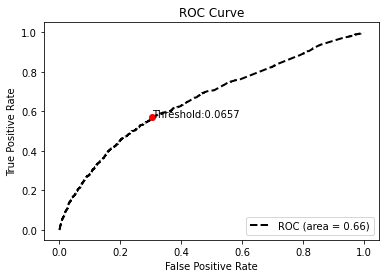

In [90]:
###最佳阈值
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point

###ROC
fpr, tpr, thersholds = roc_curve(Y_dt, Y_dt_pred_1, pos_label=1)
best_thershold, point = Find_Optimal_Cutoff(tpr, fpr, thersholds)
roc_auc = auc(fpr, tpr)
 
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
 
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.plot(point[0], point[1], marker='o', color='r')
plt.text(point[0], point[1], f'Threshold:{best_thershold:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")

In [93]:
roc_auc

0.6618685746257692

In [96]:
def ks_curve(df, num=10):
    # 防止中文乱码
    #plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False

    ks_value = df['diff'].max()
    # 获取绘制曲线所需要的数据
    x_curve = range(num + 1)
    y_curve1 = [0] + list(df['bad_percent_cum'].values[:-1])
    y_curve2 = [0] + list(df['good_percent_cum'].values[:-1])
    y_curve3 = [0] + list(df['diff'].values[:-1])
    # 获取绘制ks点所需要的数据
    df_ks_max = df[df['diff'] == ks_value]
    x_point = [df_ks_max['rank'].values[0], df_ks_max['rank'].values[0]]
    y_point = [df_ks_max['bad_percent_cum'].values[0], df_ks_max['good_percent_cum'].values[0]]
    # 绘制曲线
    plt.plot(x_curve, y_curve1, label='bad', linewidth=2)
    plt.plot(x_curve, y_curve2, label='good', linewidth=2)
    plt.plot(x_curve, y_curve3, label='diff', linewidth=2)
    # 标记ks
    plt.plot(x_point, y_point, label='ks - {:.2f}'.format(ks_value), color='r', marker='o', markerfacecolor='r', markersize=5)
    plt.scatter(x_point, y_point, color='r')
    plt.title('K-S')
    plt.legend()
    plt.show()
    
    return ks_value

In [95]:
### KS
def ks(df, y_true, y_pre, num=10, good=1, bad=0):
    # 1.将数据从小到大平均分成num组
    df_ks = df.sort_values(y_pre).reset_index(drop=True)
    df_ks['rank'] = np.floor((df_ks.index / len(df_ks) * num) + 1)
    df_ks['set_1'] = 1
    # 2.统计结果
    result_ks = pd.DataFrame()
    result_ks['group_sum'] = df_ks.groupby('rank')['set_1'].sum()
    result_ks['group_min'] = df_ks.groupby('rank')[y_pre].min()
    result_ks['group_max'] = df_ks.groupby('rank')[y_pre].max()
    result_ks['group_mean'] = df_ks.groupby('rank')[y_pre].mean()
    # 3.最后一行添加total汇总数据
    result_ks.loc['total', 'group_sum'] = df_ks['set_1'].sum()
    result_ks.loc['total', 'group_min'] = df_ks[y_pre].min()
    result_ks.loc['total', 'group_max'] = df_ks[y_pre].max()
    result_ks.loc['total', 'group_mean'] = df_ks[y_pre].mean()
    # 4.好用户统计
    result_ks['good_sum'] = df_ks[df_ks[y_true] == good].groupby('rank')['set_1'].sum()
    result_ks.good_sum.replace(np.nan, 0, inplace=True)
    result_ks.loc['total', 'good_sum'] = result_ks['good_sum'].sum()
    result_ks['good_percent'] = result_ks['good_sum'] / result_ks.loc['total', 'good_sum']
    result_ks['good_percent_cum'] = result_ks['good_sum'].cumsum() / result_ks.loc['total', 'good_sum']
    # 5.坏用户统计
    result_ks['bad_sum'] = df_ks[df_ks[y_true] == bad].groupby('rank')['set_1'].sum()
    result_ks.bad_sum.replace(np.nan, 0, inplace=True)
    result_ks.loc['total', 'bad_sum'] = result_ks['bad_sum'].sum()
    result_ks['bad_percent'] = result_ks['bad_sum'] / result_ks.loc['total', 'bad_sum']
    result_ks['bad_percent_cum'] = result_ks['bad_sum'].cumsum() / result_ks.loc['total', 'bad_sum']
    # 6.计算ks值
    result_ks['diff'] = result_ks['bad_percent_cum'] - result_ks['good_percent_cum']
    # 7.更新最后一行total的数据
    result_ks.loc['total', 'bad_percent_cum'] = np.nan
    result_ks.loc['total', 'good_percent_cum'] = np.nan
    result_ks.loc['total', 'diff'] = result_ks['diff'].max()
    
    result_ks = result_ks.reset_index()
    
    return result_ks

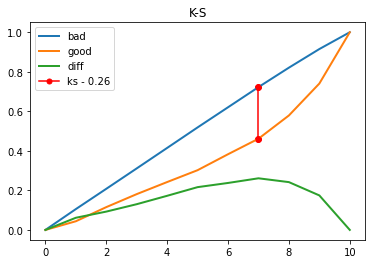

0.26113220993801634

In [97]:
ks_df = pd.DataFrame()
ks_df['score']=Y_dt_pred_1
ks_df['label']=list(Y_dt)
result_ks = ks(ks_df, 'label', 'score')
ks_curve(result_ks)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 25151 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 24314 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 30005 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 21147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 20844 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 36335 missing from current font.
  font.set_

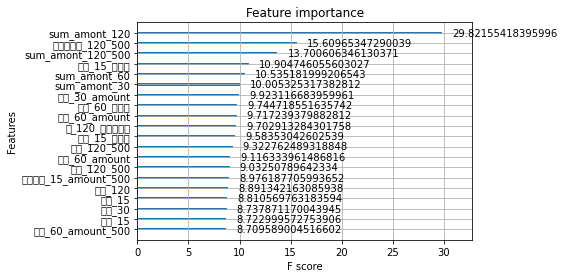

In [98]:
xgb.plot_importance(best_estimator,max_num_features=20,importance_type='gain')

In [99]:
weight = pd.Series(best_estimator.get_booster().get_score(importance_type='gain')).sort_values(ascending=False).head(20)
weight

sum_amont_120         29.821554
去重工程数_120_500         15.609653
sum_amont_120_500     13.700606
公路_15_工程数             10.904746
sum_amont_60          10.535182
sum_amont_30          10.005325
房建_30_amount           9.923117
电力_60_工程数              9.744719
通信_60_amount           9.717239
无_120_去重工程数            9.702913
机电_15_工程数              9.583530
公路_120_500             9.322762
房建_60_amount           9.116334
房建_120_500             9.032508
装修装饰_15_amount_500     8.976188
通信_120                 8.891342
公路_15                  8.810570
电力_30                  8.737871
电力_15                  8.723000
房建_60_amount_500       8.709589
dtype: float64